(mmm_multidimensional_example)=
# MMM Multidimensional Example Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/Documents/pymc-marketing/pymc_marketing/mmm/multidimensional.py:56: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


In [2]:
data_path = data_dir / "mmm_example.csv"

raw_data_df = pd.read_csv(data_path, parse_dates=["date_week"])

raw_data_df = raw_data_df.rename(columns={"date_week": "date"})

raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       179 non-null    datetime64[ns]
 1   y          179 non-null    float64       
 2   x1         179 non-null    float64       
 3   x2         179 non-null    float64       
 4   event_1    179 non-null    float64       
 5   event_2    179 non-null    float64       
 6   dayofyear  179 non-null    int64         
 7   t          179 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 11.3 KB


In [3]:
a_data_df = raw_data_df.copy().assign(geo="geo_a")

b_data_df = raw_data_df.copy().assign(geo="geo_b")

rng = np.random.default_rng(42)

b_data_df["y"] = b_data_df["y"] + 1_000 * rng.normal(size=len(b_data_df))

data_df = pd.concat([a_data_df, b_data_df])

data_df = data_df.assign(y_max=lambda x: x["y"].max()).assign(
    y_scaled=lambda x: x["y"] / x["y_max"]
)

data_df.head()

date            y        x1   x2  event_1  event_2  dayofyear  t  \
0 2018-04-02  3984.662237  0.318580  0.0      0.0      0.0         92  0   
1 2018-04-09  3762.871794  0.112388  0.0      0.0      0.0         99  1   
2 2018-04-16  4466.967388  0.292400  0.0      0.0      0.0        106  2   
3 2018-04-23  3864.219373  0.071399  0.0      0.0      0.0        113  3   
4 2018-04-30  4441.625278  0.386745  0.0      0.0      0.0        120  4   

     geo       y_max  y_scaled  
0  geo_a  8915.67745  0.446928  
1  geo_a  8915.67745  0.422051  
2  geo_a  8915.67745  0.501024  
3  geo_a  8915.67745  0.433418  
4  geo_a  8915.67745  0.498181

/Users/juanitorduz/Documents/envs/pymc-marketing-env/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


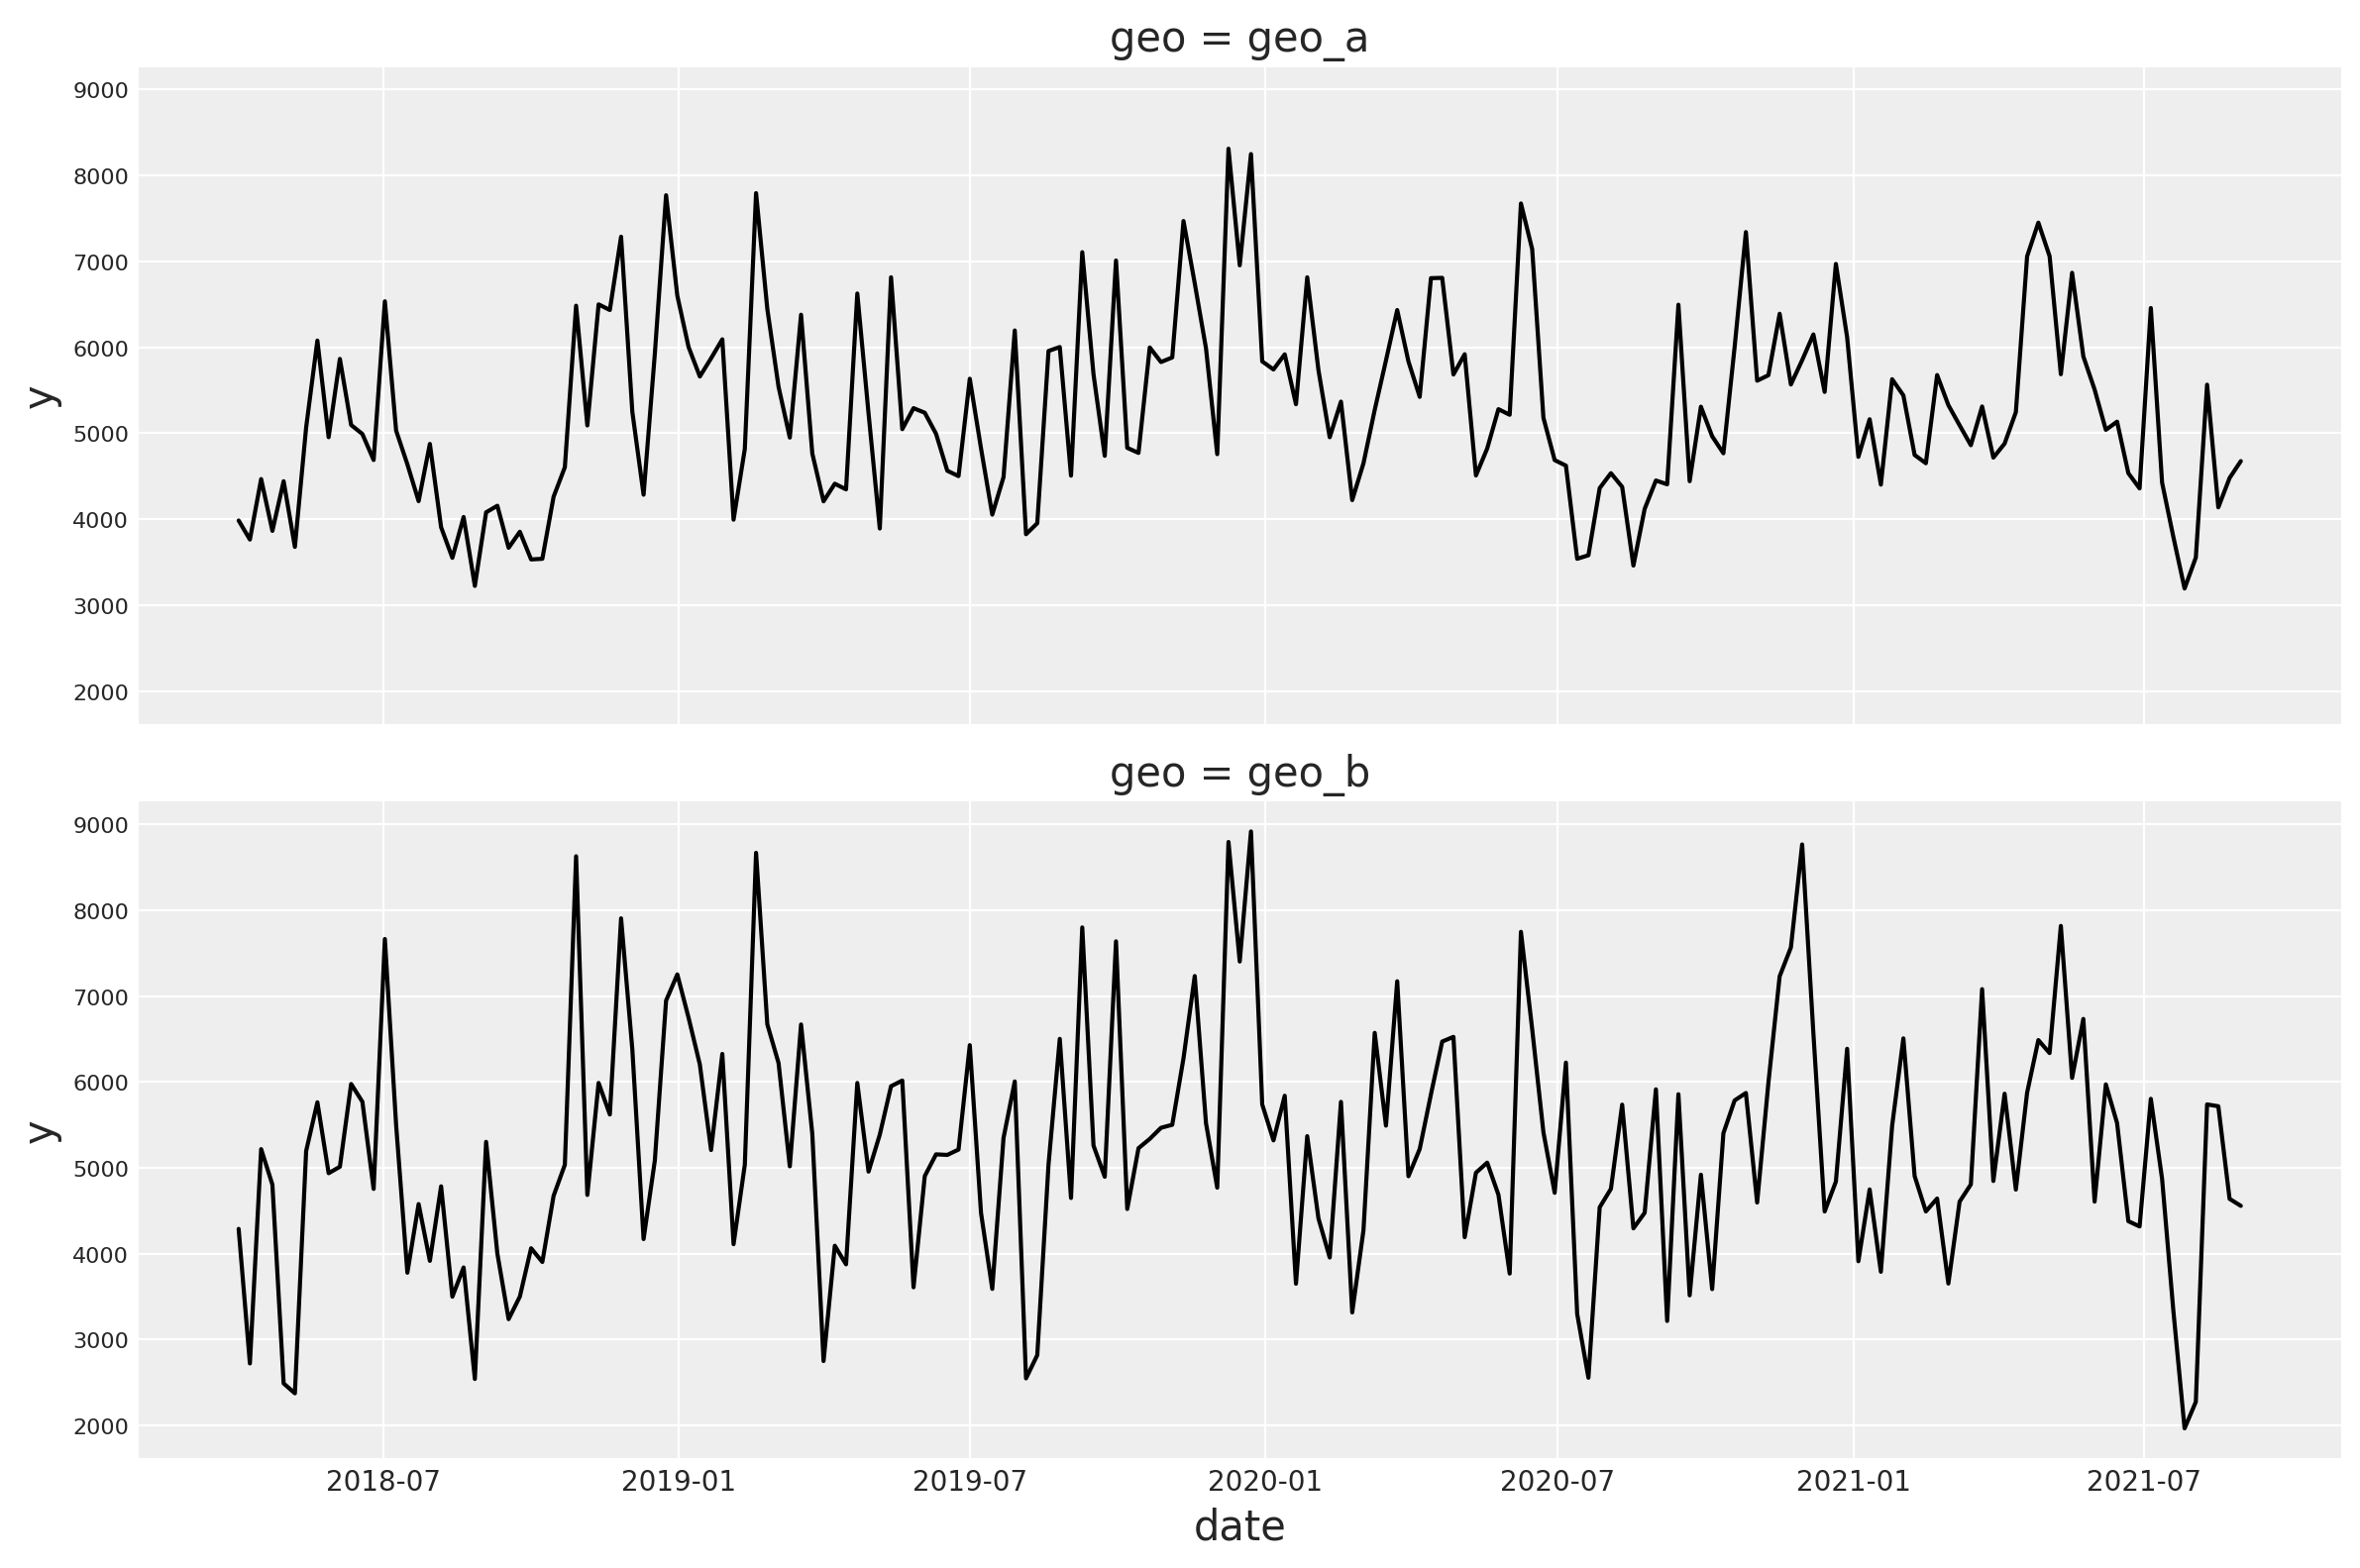

In [4]:
g = sns.relplot(
    data=data_df,
    x="date",
    y="y",
    color="black",
    col="geo",
    col_wrap=1,
    kind="line",
    height=4,
    aspect=3,
)

In [5]:
channel_columns = ["x1", "x2"]
n_channels = len(channel_columns)

sum_spend_geo_channel = data_df.groupby(["geo"]).agg({"x1": "sum", "x2": "sum"})

spend_share = (
    sum_spend_geo_channel.to_numpy() / sum_spend_geo_channel.sum(axis=1).to_numpy()
)

prior_sigma = n_channels * spend_share

In [6]:
saturation = LogisticSaturation(
    priors={
        "beta": Prior("HalfNormal", sigma=prior_sigma, dims=("channel", "geo")),
        "lam": Prior(
            "Gamma",
            mu=Prior("LogNormal", mu=np.log(3), sigma=np.log(1.5), dims="geo"),
            sigma=Prior("LogNormal", mu=np.log(1), sigma=np.log(1.5), dims="geo"),
            dims=("channel", "geo"),
        ),
    }
)

saturation.model_config

{'saturation_lam': Prior("Gamma", mu=Prior("LogNormal", mu=1.0986122886681098, sigma=0.4054651081081644, dims="geo"), sigma=Prior("LogNormal", mu=0.0, sigma=0.4054651081081644, dims="geo"), dims=("channel", "geo")),
 'saturation_beta': Prior("HalfNormal", sigma=[[1.31263903 0.68736097]
  [1.31263903 0.68736097]], dims=("channel", "geo"))}

In [7]:
adstock = GeometricAdstock(
    priors={"alpha": Prior("Beta", alpha=2, beta=3, dims="channel")}, l_max=8
)

adstock.model_config

{'adstock_alpha': Prior("Beta", alpha=2, beta=3, dims="channel")}

In [8]:
model_config = {
    "intercept": Prior("Normal", mu=0.5, sigma=0.5, dims="geo"),
    "gamma_control": Prior("Normal", mu=0, sigma=0.5, dims="control"),
    "gamma_fourier": Prior("Laplace", mu=0, b=0.5, dims=("geo", "fourier_mode")),
    "likelihood": Prior(
        "Normal",
        sigma=Prior("HalfNormal", sigma=Prior("HalfNormal", sigma=2)),
        dims=("date", "geo"),
    ),
}

In [9]:
mmm = MMM(
    date_column="date",
    target_column="y",
    channel_columns=["x1", "x2"],
    control_columns=["event_1", "event_2", "t"],
    dims=("geo",),
    adstock=adstock,
    saturation=saturation,
    yearly_seasonality=2,
    model_config=model_config,
)

In [10]:
mmm.model_config

{'intercept': Prior("Normal", mu=0.5, sigma=0.5, dims="geo"),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=Prior("HalfNormal", sigma=2)), dims=("date", "geo")),
 'gamma_control': Prior("Normal", mu=0, sigma=0.5, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=0.5, dims=("geo", "fourier_mode")),
 'adstock_alpha': Prior("Beta", alpha=2, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", mu=Prior("LogNormal", mu=1.0986122886681098, sigma=0.4054651081081644, dims="geo"), sigma=Prior("LogNormal", mu=0.0, sigma=0.4054651081081644, dims="geo"), dims=("channel", "geo")),
 'saturation_beta': Prior("HalfNormal", sigma=[[1.31263903 0.68736097]
  [1.31263903 0.68736097]], dims=("channel", "geo"))}

In [11]:
x_train = data_df.drop(columns=["y", "y_max", "y_scaled"])

y_train = data_df["y"]

In [12]:
mmm.build_model(X=x_train, y=y_train)

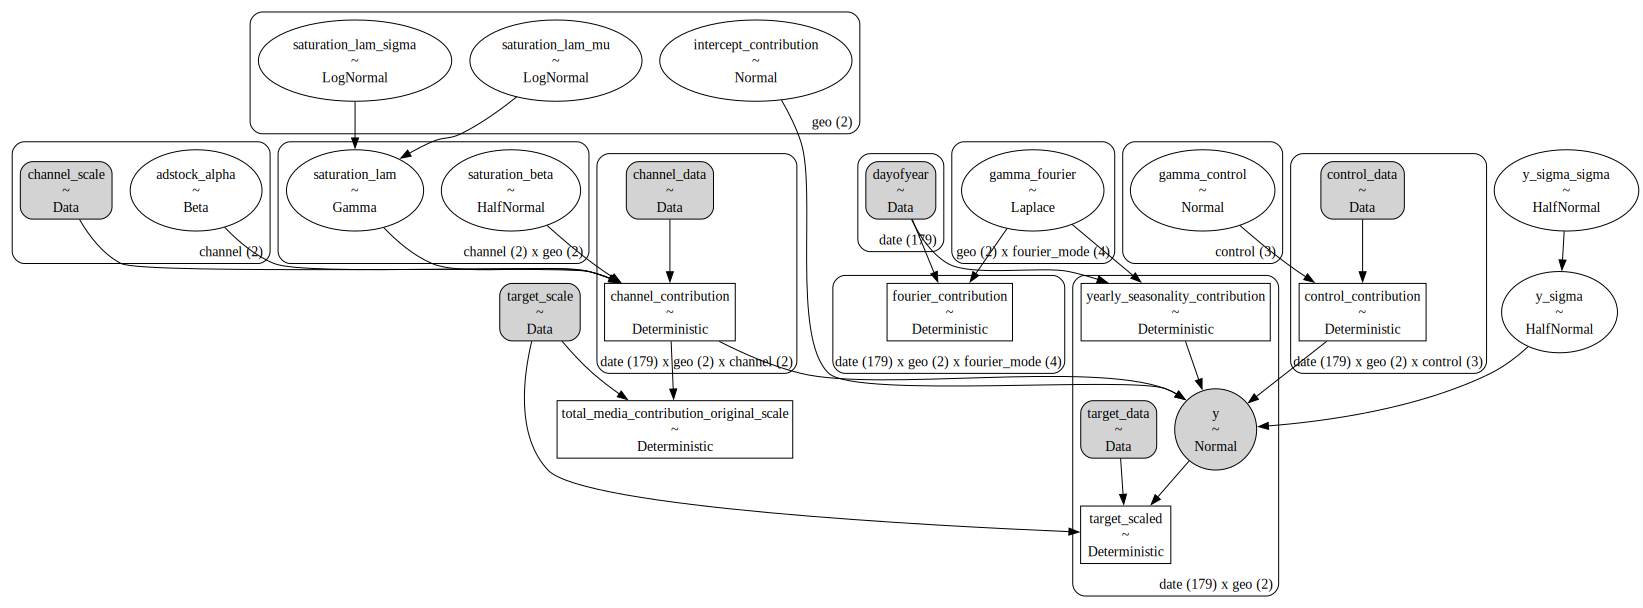

In [13]:
pm.model_to_graphviz(mmm.model)

In [14]:
mmm.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "control_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
    ]
)

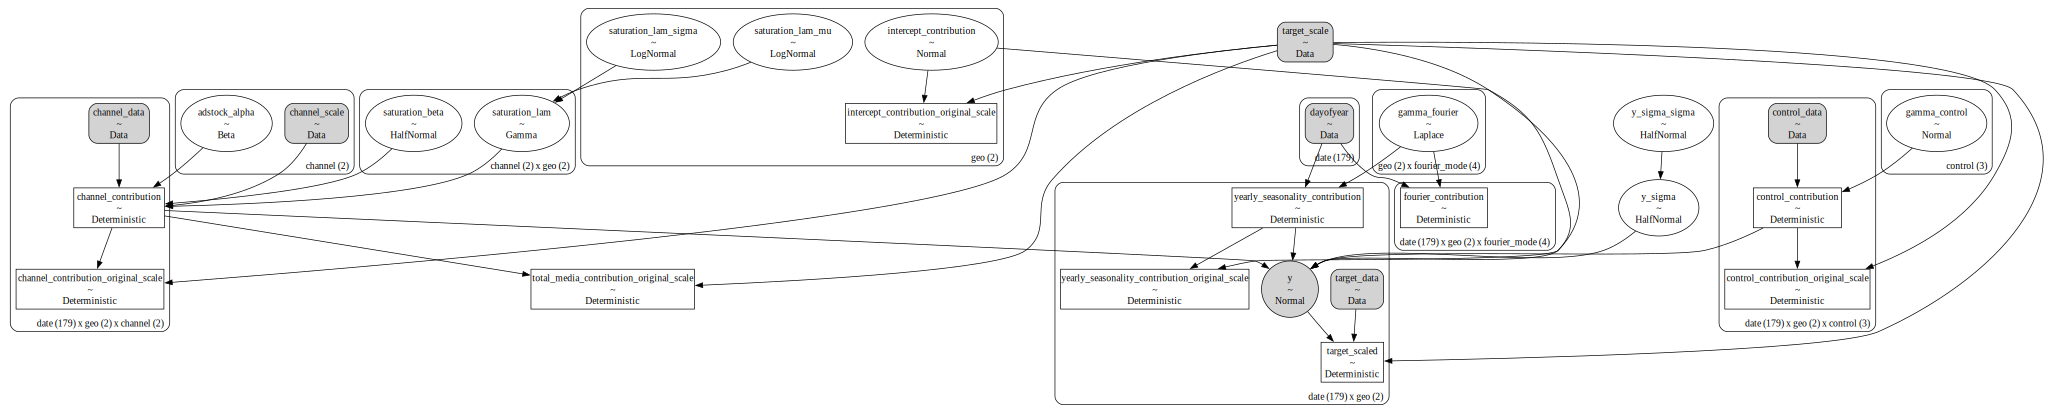

In [15]:
pm.model_to_graphviz(mmm.model)

In [16]:
prior_predictive = mmm.sample_prior_predictive(X=x_train, samples=1_000)

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept_contribution, saturation_beta, saturation_lam, saturation_lam_mu, saturation_lam_sigma, y, y_sigma, y_sigma_sigma]


/Users/juanitorduz/Documents/envs/pymc-marketing-env/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


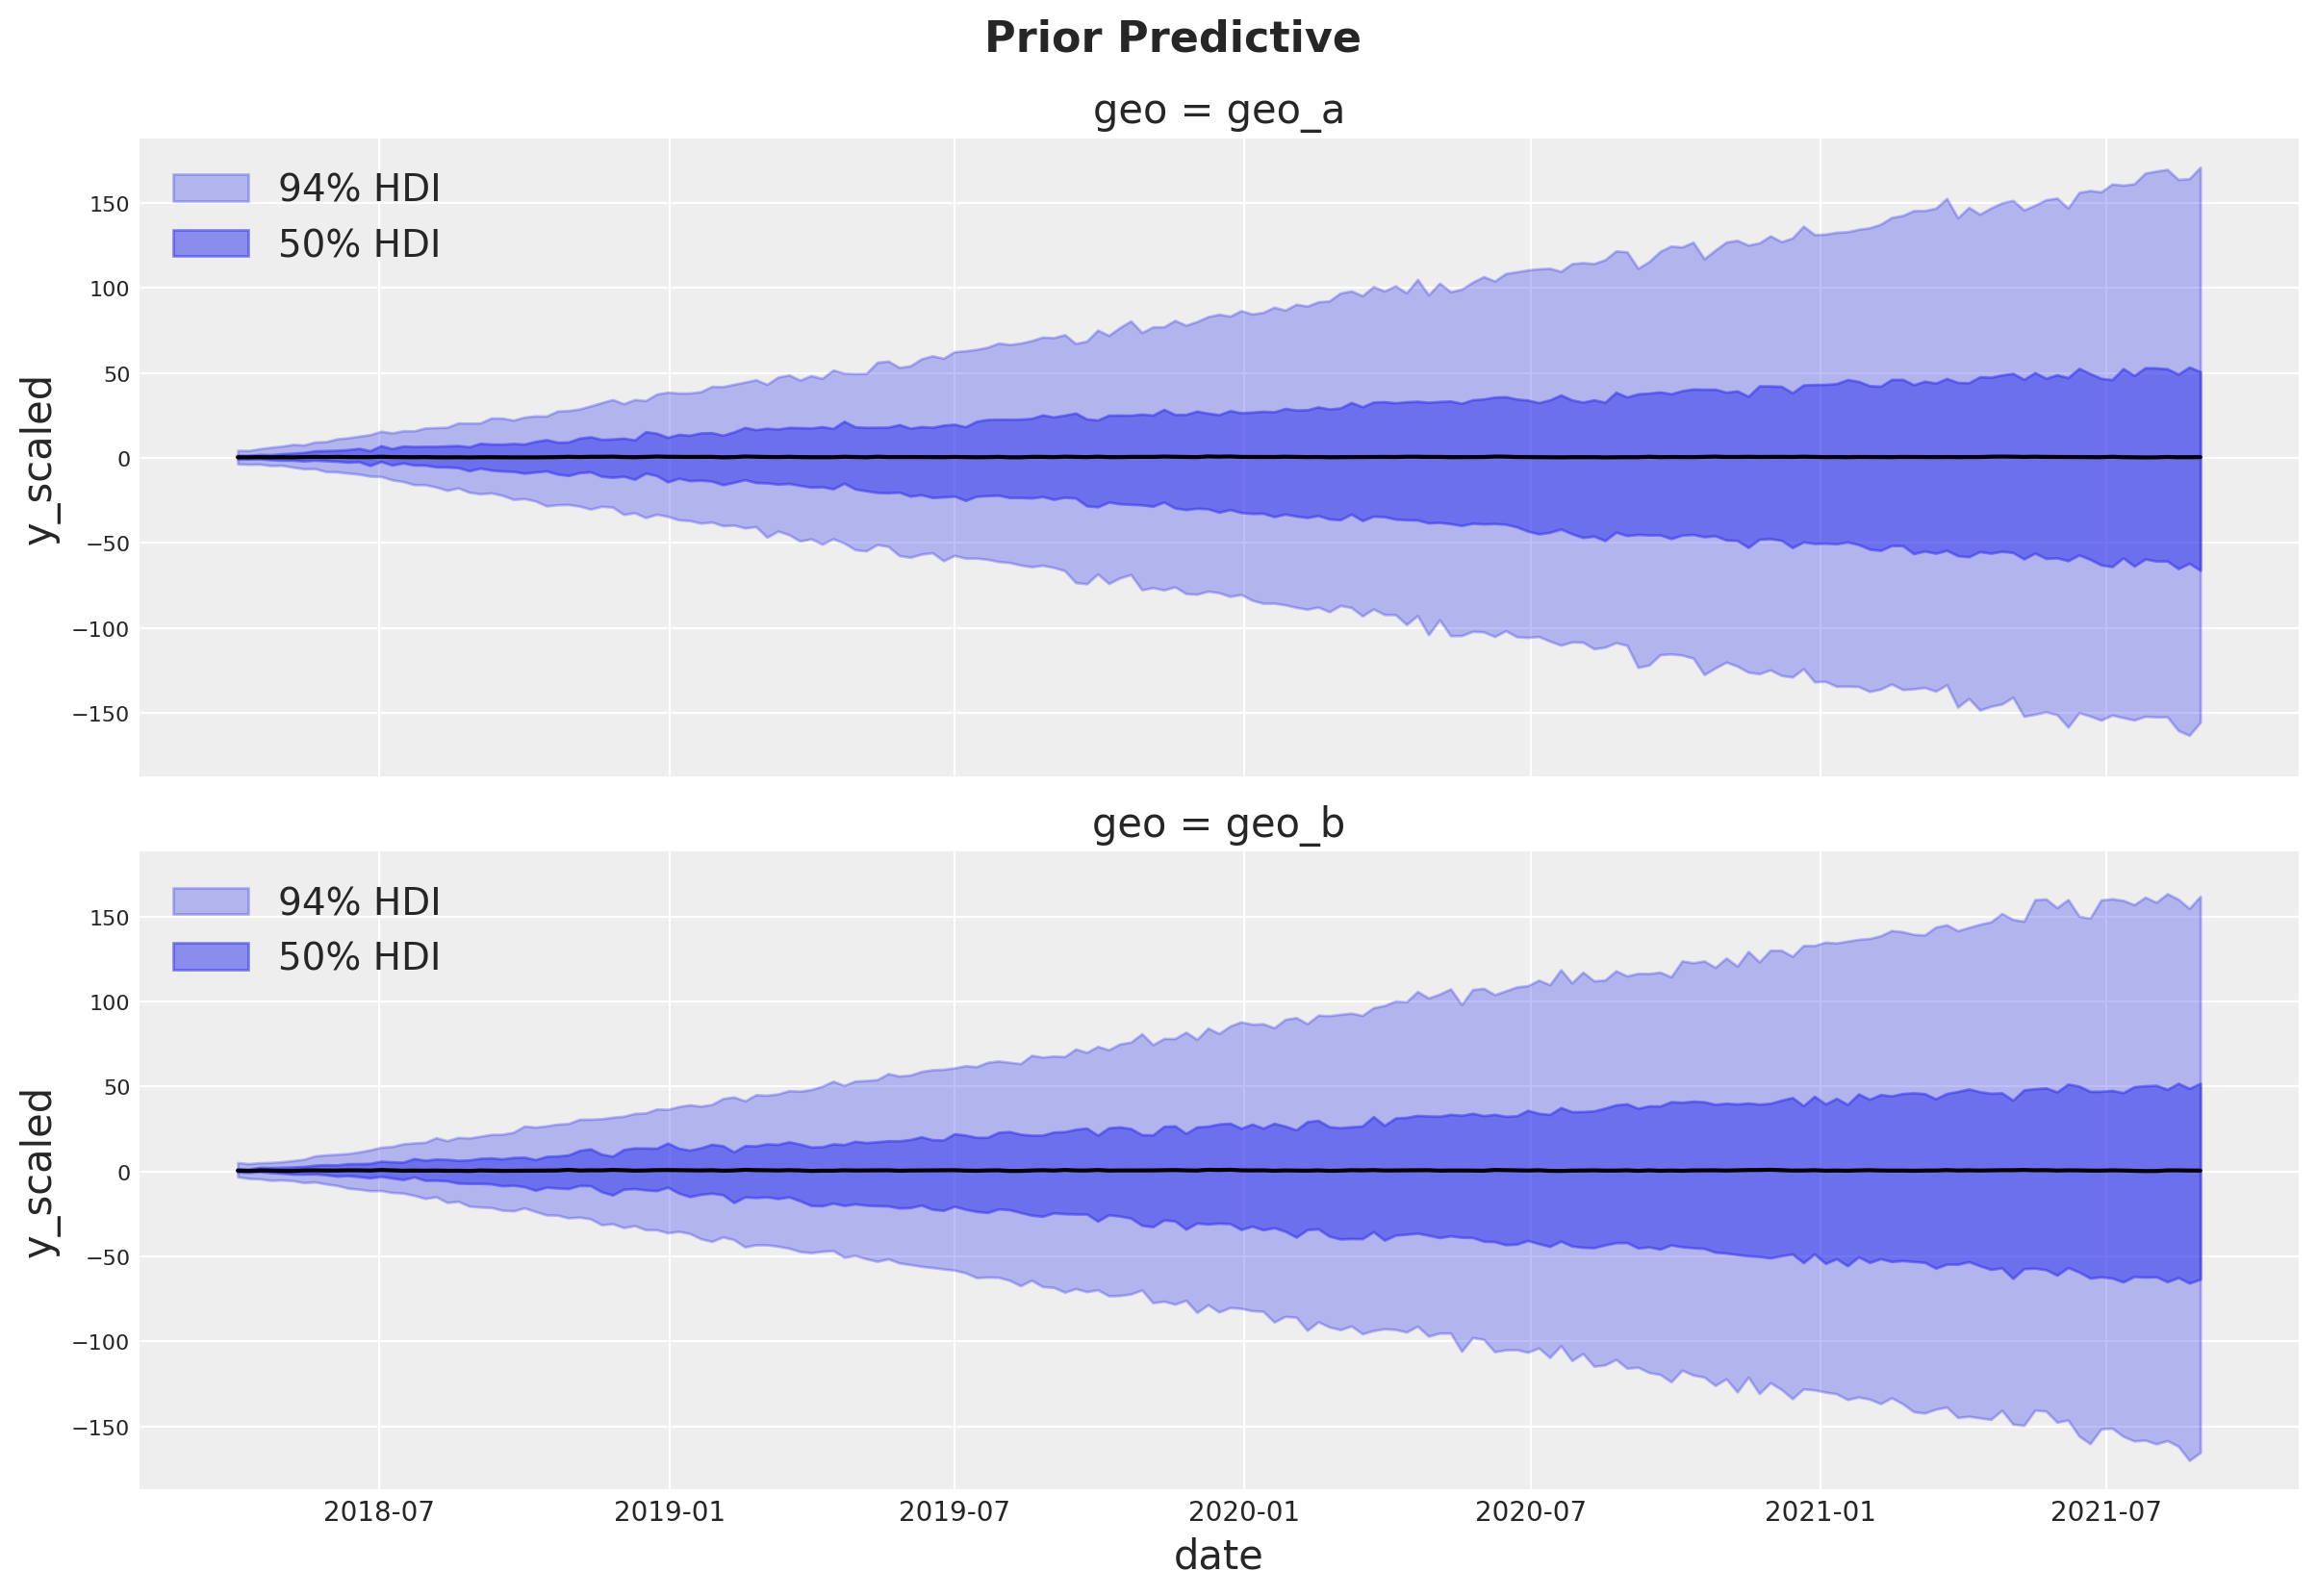

In [17]:
g = sns.relplot(
    data=data_df,
    x="date",
    y="y_scaled",
    color="black",
    col="geo",
    col_wrap=1,
    kind="line",
    height=4,
    aspect=3,
)

axes = g.axes.flatten()

for ax, geo in zip(axes, mmm.model.coords["geo"], strict=True):
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=prior_predictive.sel(geo=geo)["y"].unstack().transpose(..., "date"),
        smooth=False,
        color="C0",
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.3, "label": "94% HDI"},
        ax=ax,
    )
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=prior_predictive.sel(geo=geo)["y"].unstack().transpose(..., "date"),
        smooth=False,
        color="C0",
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.5, "label": "50% HDI"},
        ax=ax,
    )
    ax.legend(loc="upper left")

g.figure.suptitle("Prior Predictive", fontsize=16, fontweight="bold", y=1.03);

In [18]:
mmm.fit(
    X=x_train,
    y=y_train,
    chains=4,
    target_accept=0.9,
    nuts_sampler="nutpie",
    random_seed=42,
)

mmm.sample_posterior_predictive(
    X=x_train,
    extend_idata=True,
    combined=True,
    random_seed=42,
)

Sampling: [y]


Output()

<xarray.Dataset> Size: 12MB
Dimensions:  (date: 179, geo: 2, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2018-04-02 2018-04-09 ... 2021-08-30
  * geo      (geo) <U5 40B 'geo_a' 'geo_b'
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, geo, sample) float64 11MB 0.4732 0.6048 ... 0.5443 0.4641
Attributes:
    created_at:                 2025-03-16T13:58:42.553965+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.21.1

In [19]:
mmm.idata.sample_stats.diverging.sum().item()

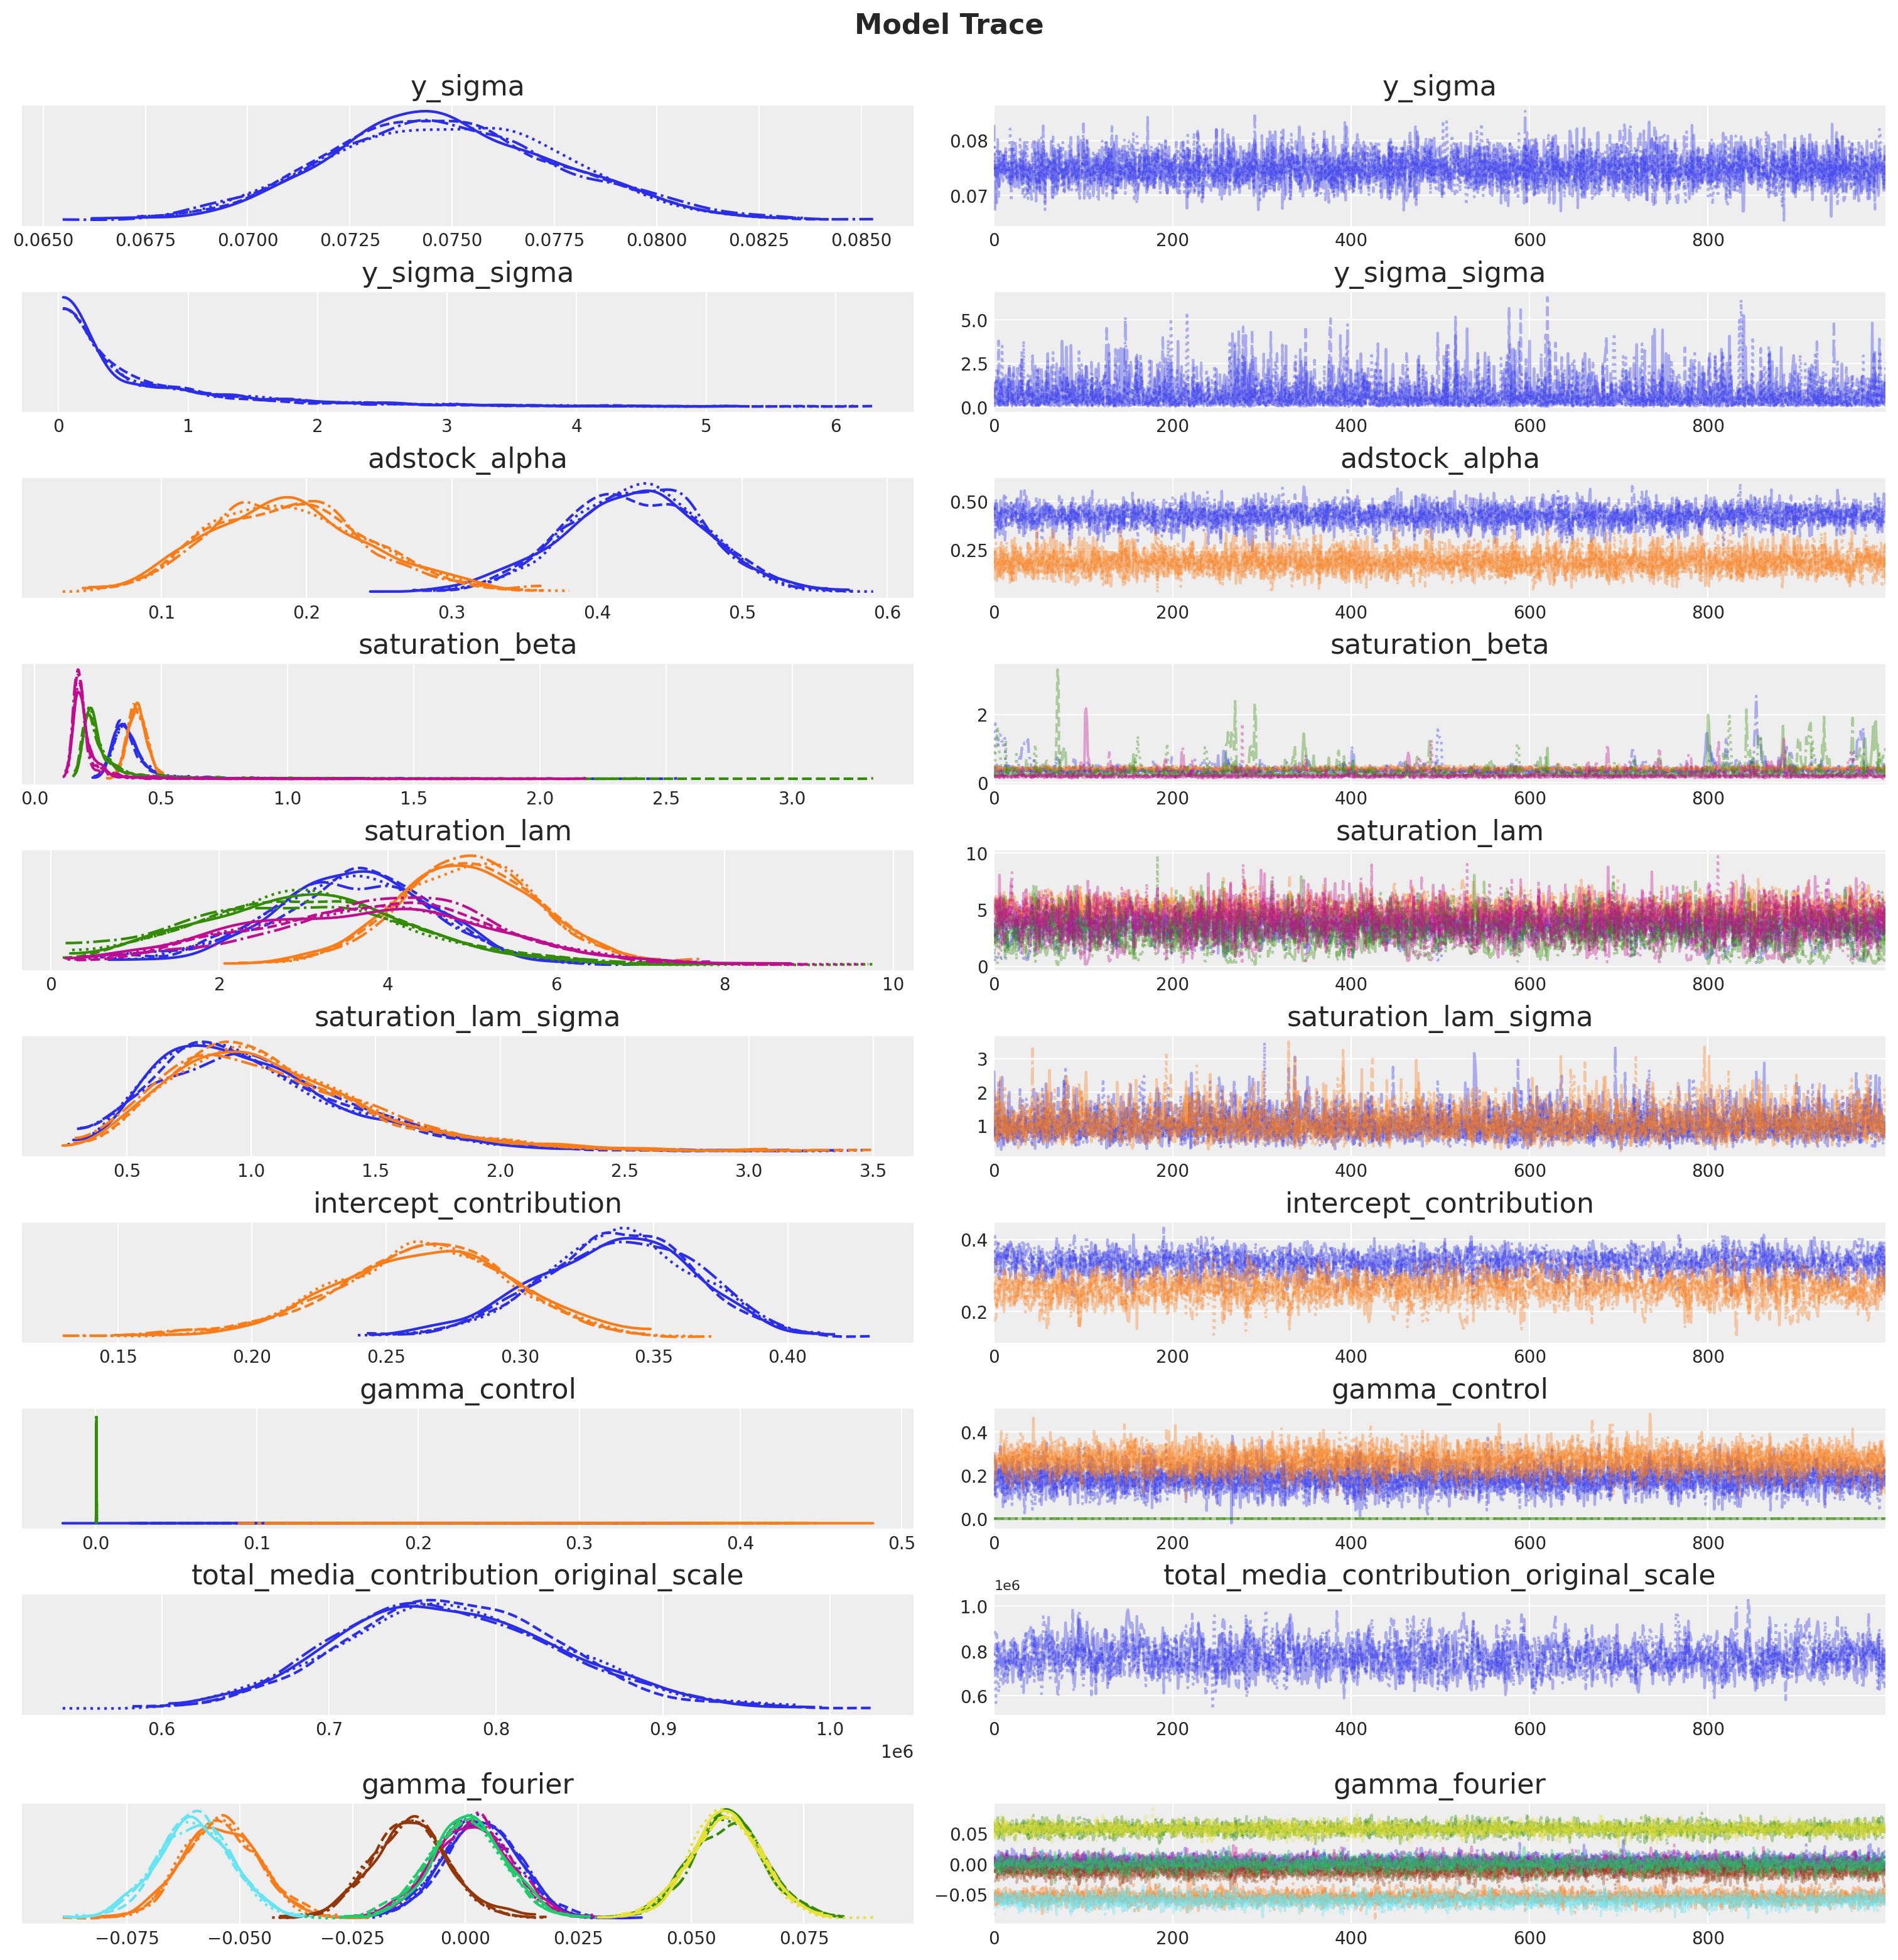

In [20]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "y_sigma",
        "y_sigma_sigma",
        "adstock_alpha",
        "saturation_beta",
        "saturation_lam",
        "saturation_lam_sigma",
        "intercept_contribution",
        "gamma_control",
        "total_media_contribution_original_scale",
        "gamma_fourier",
    ],
    compact=True,
    backend_kwargs={"figsize": (15, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16, fontweight="bold", y=1.03);

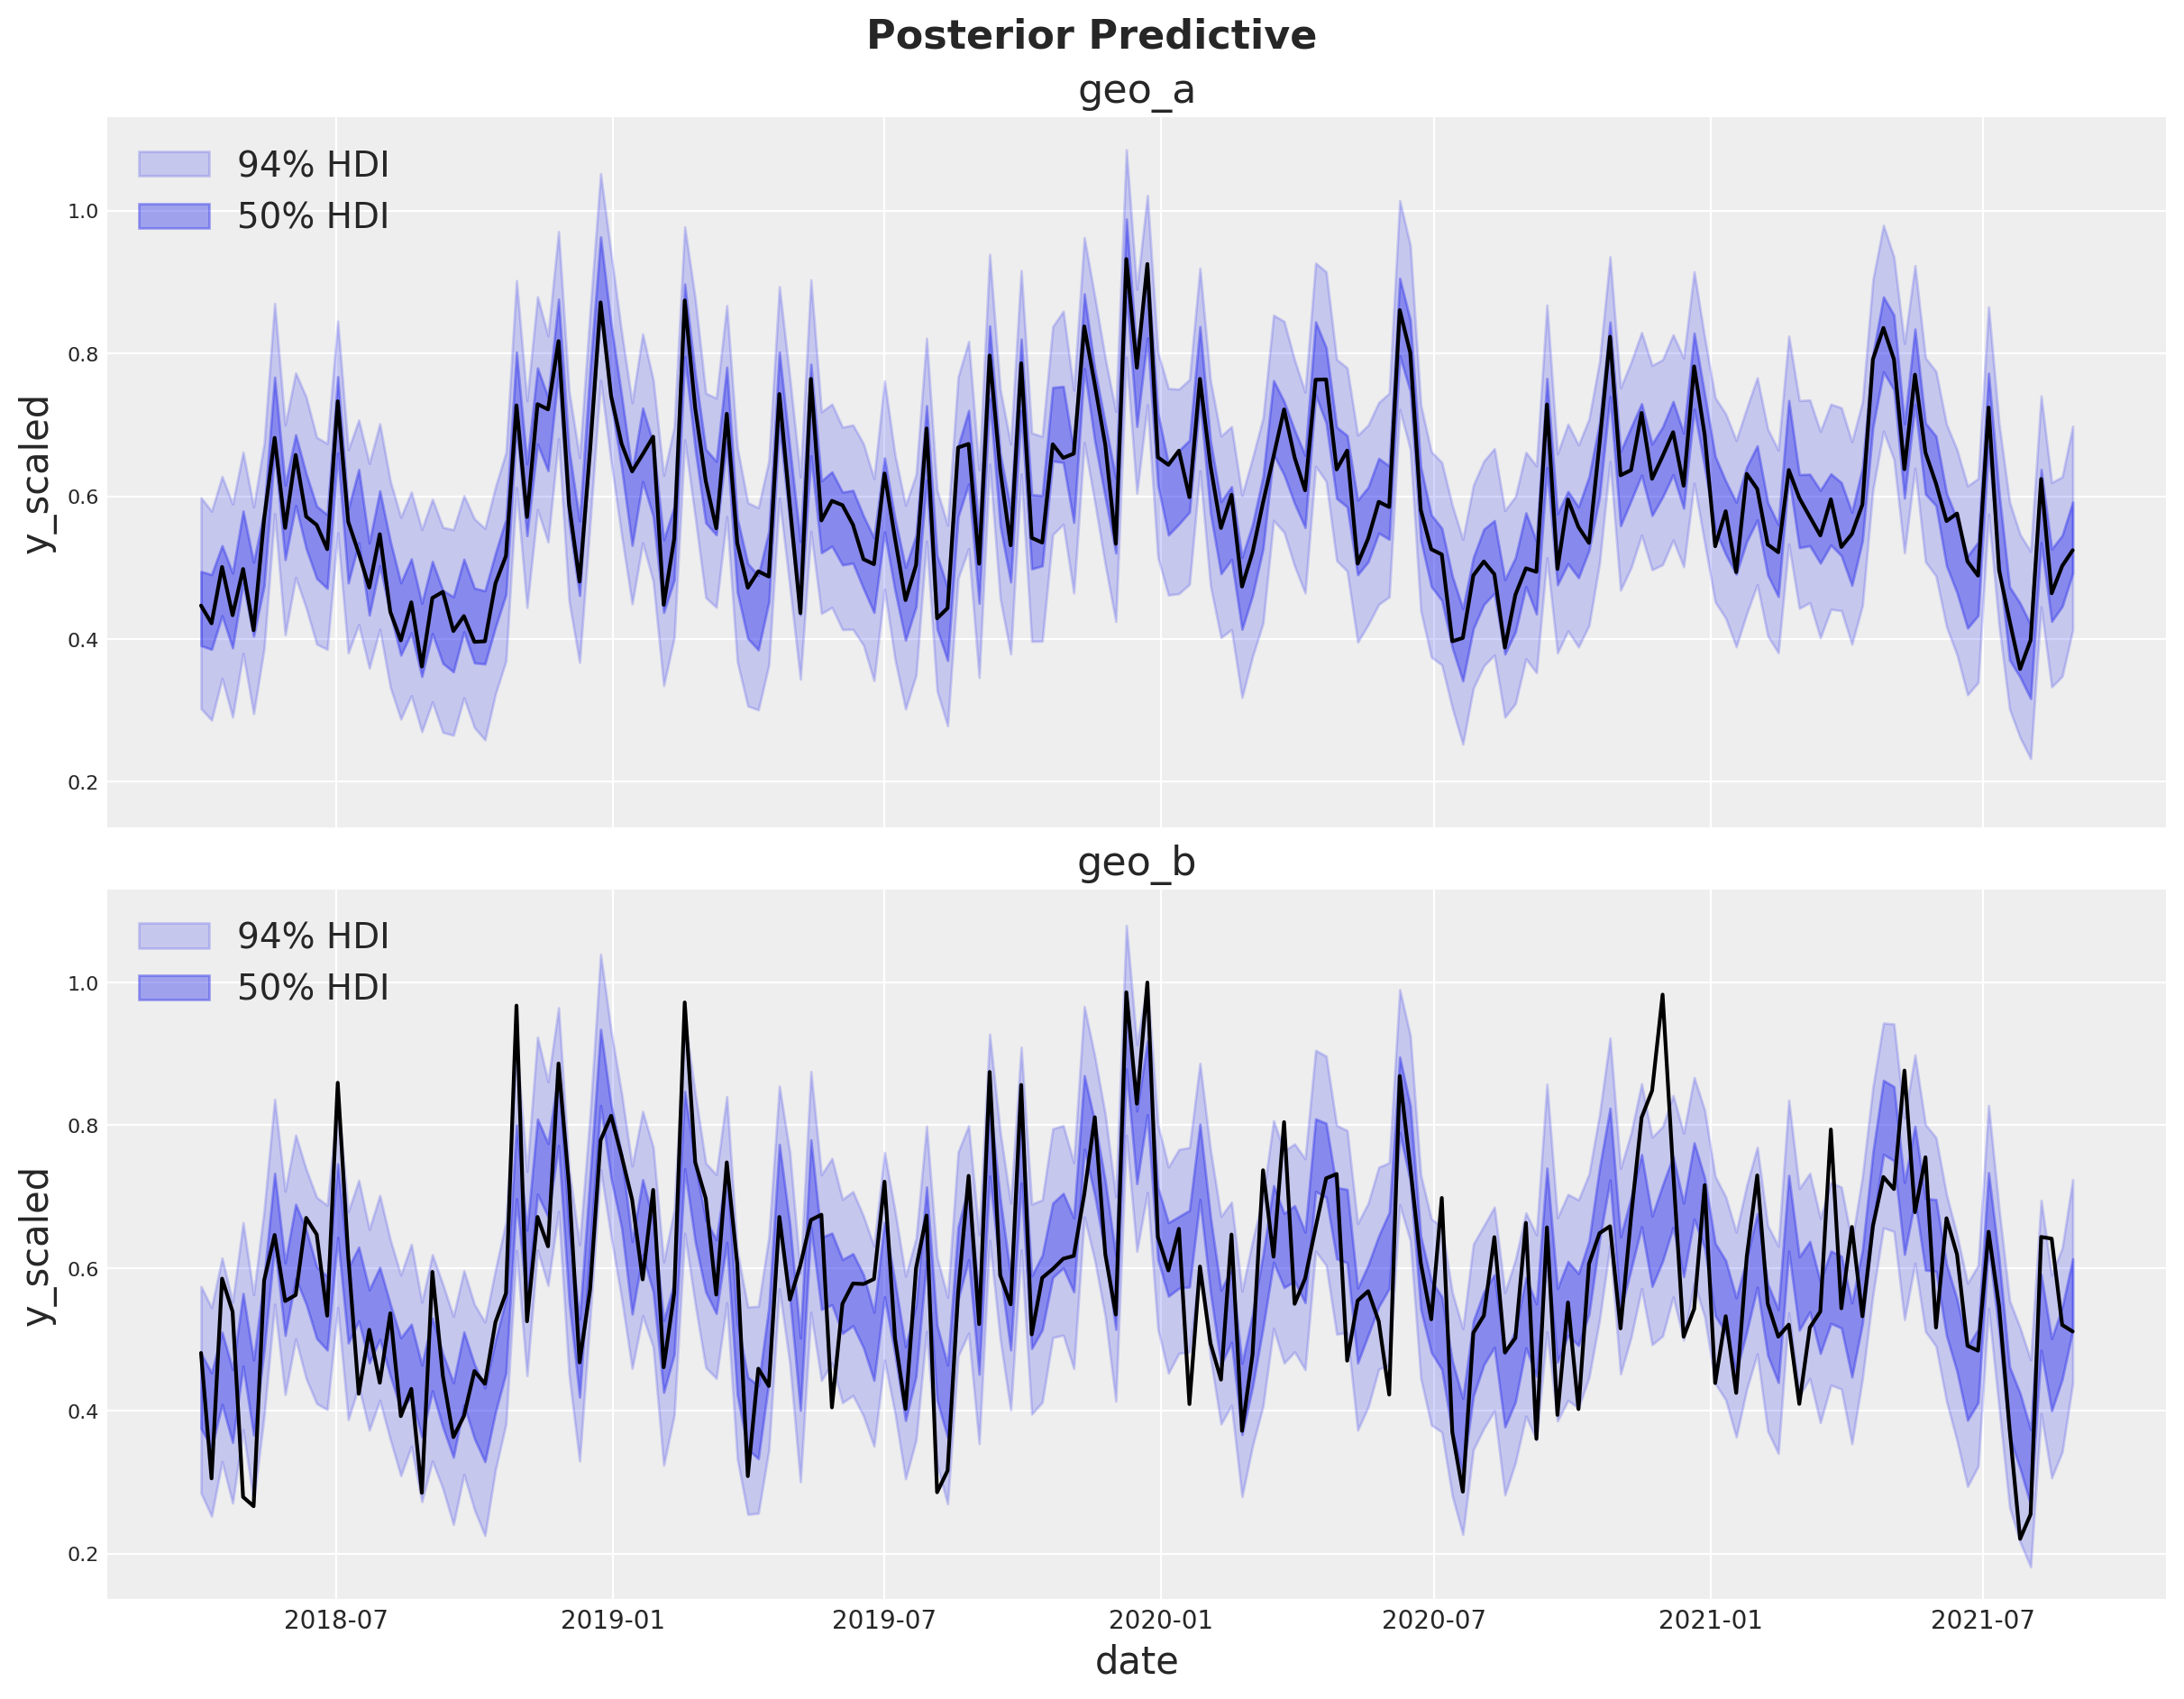

In [21]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
    figsize=(12, 9),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    ax = axes[i]
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=mmm.idata["posterior_predictive"].sel(geo=geo)["y"],
        color="C0",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.2, "label": "94% HDI"},
        ax=ax,
    )

    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=mmm.idata["posterior_predictive"].sel(geo=geo)["y"],
        color="C0",
        smooth=False,
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.4, "label": "50% HDI"},
        ax=ax,
    )

    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y_scaled",
        color="black",
        ax=ax,
    )

    ax.legend(loc="upper left")
    ax.set(title=f"{geo}")

fig.suptitle("Posterior Predictive", fontsize=16, fontweight="bold", y=1.03);

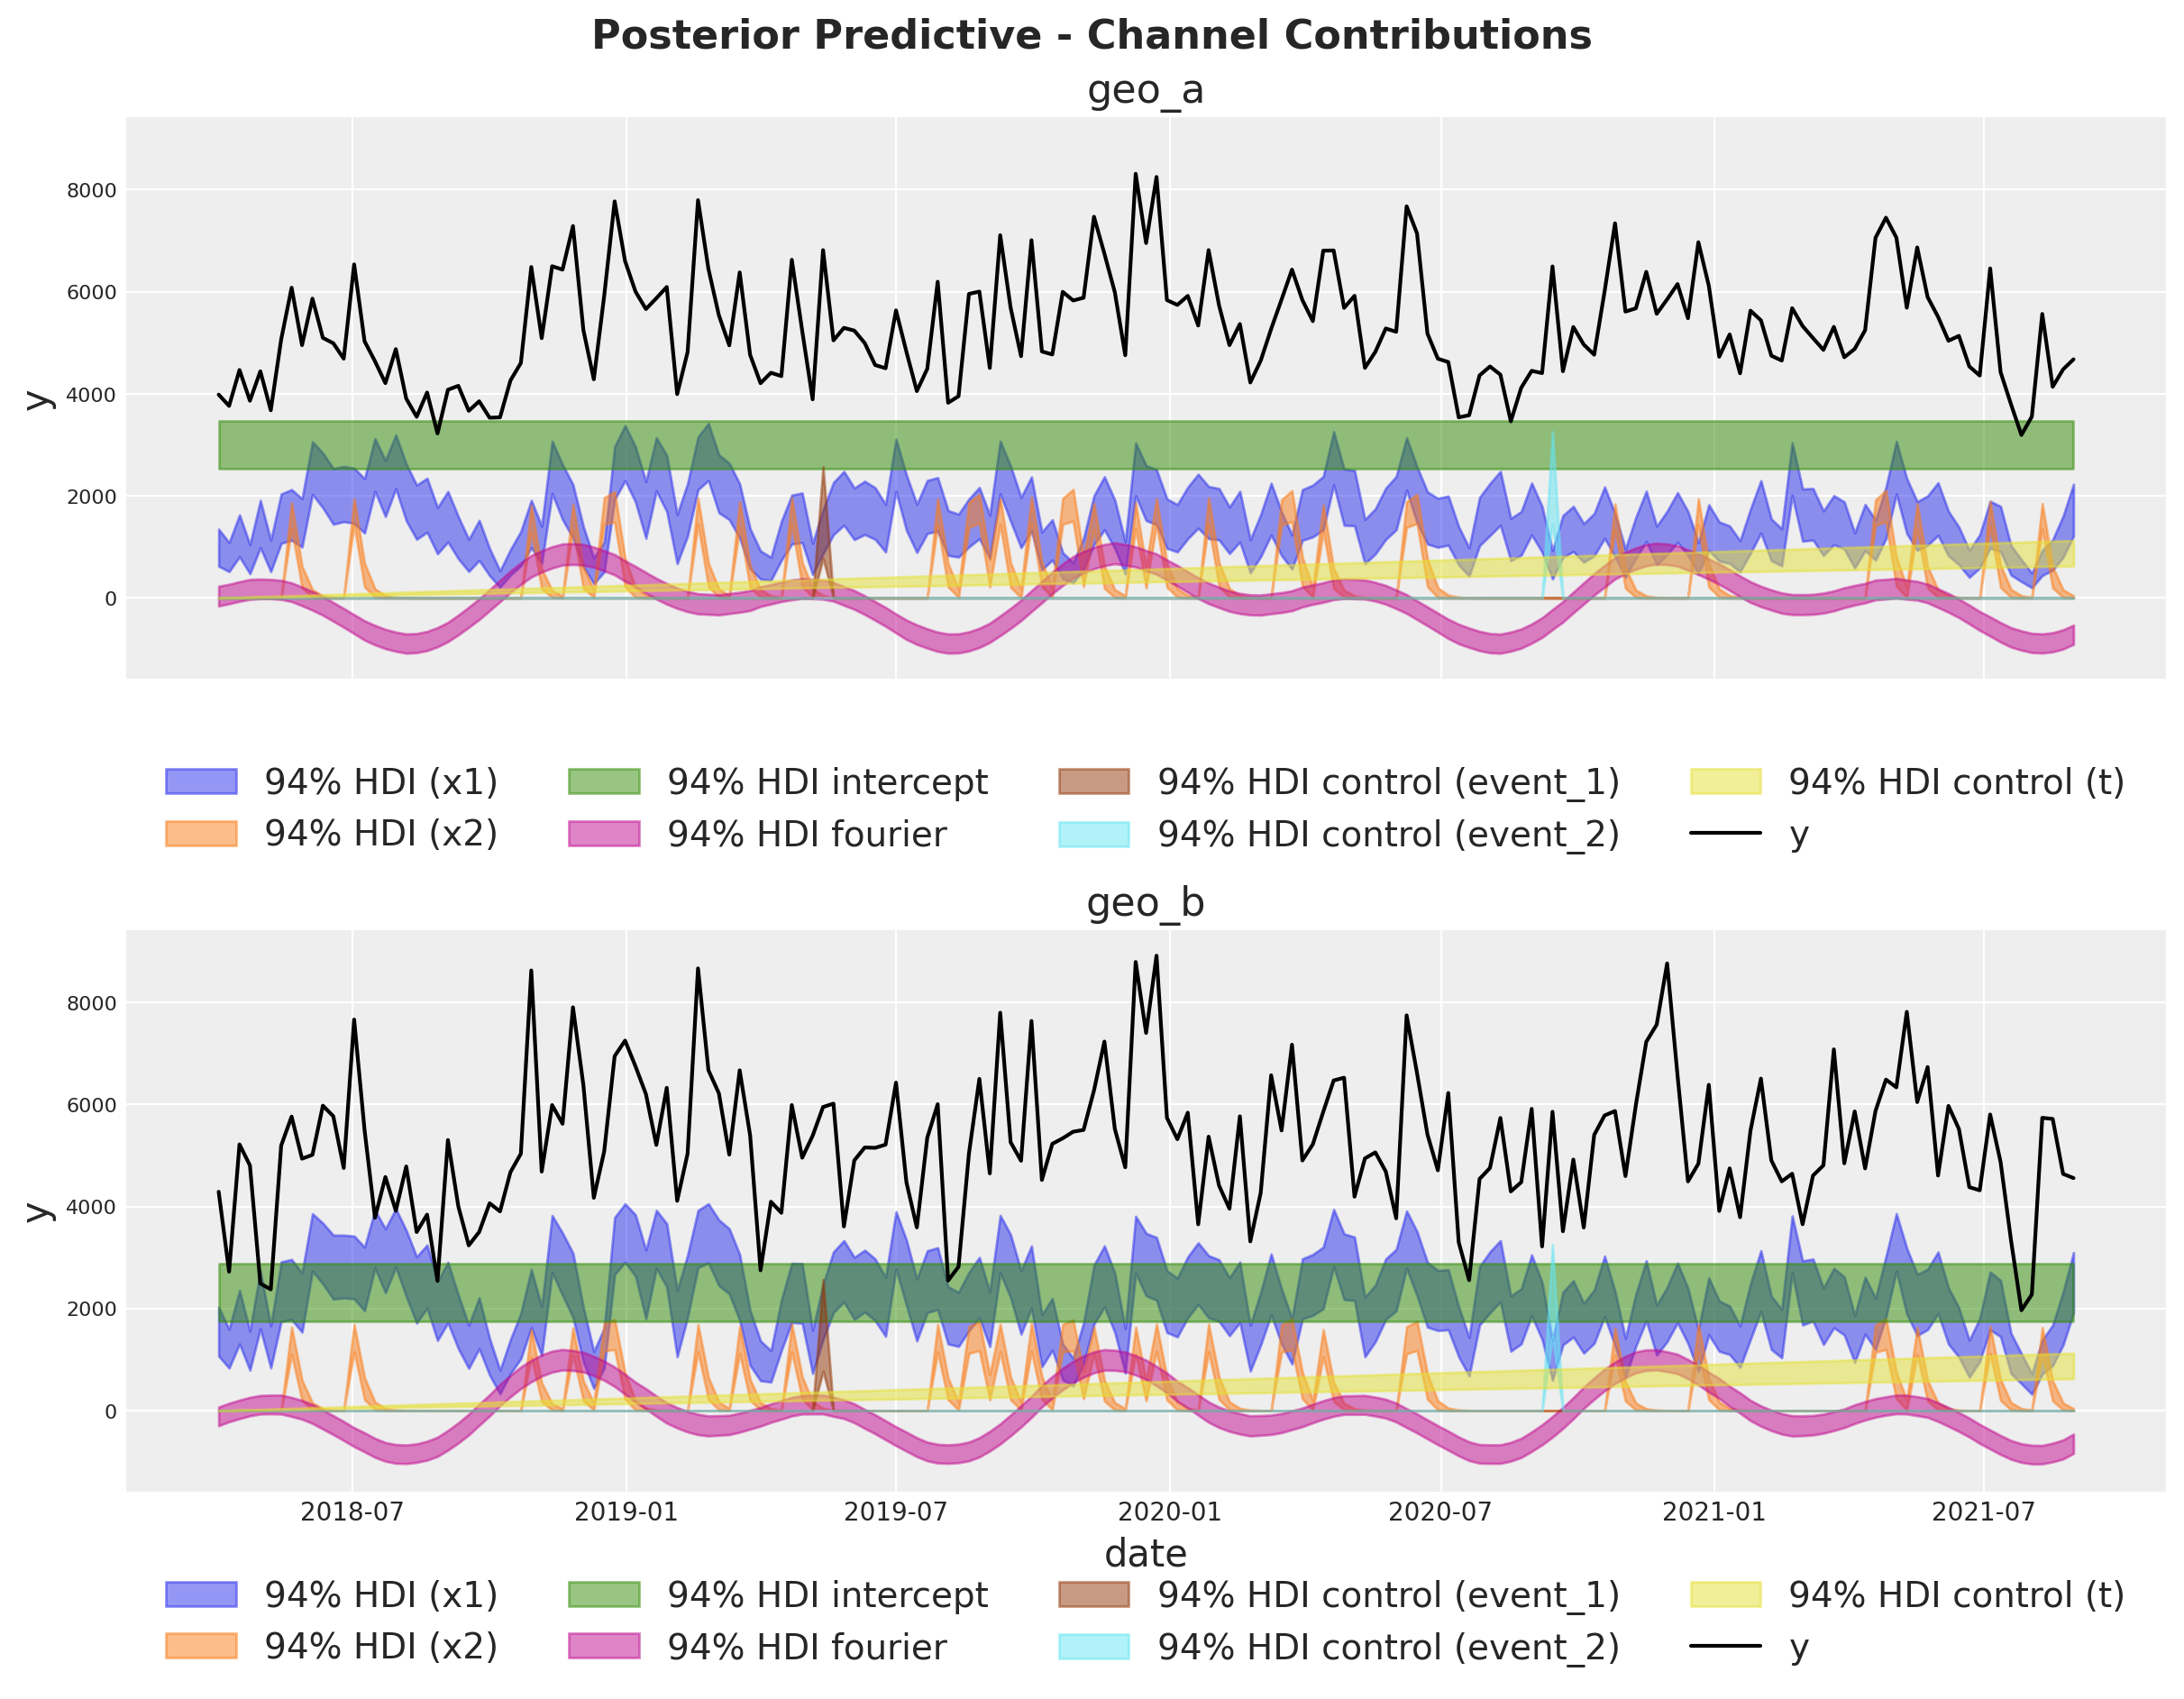

In [22]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
    figsize=(12, 9),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    ax = axes[i]

    for j, channel in enumerate(mmm.model.coords["channel"]):
        az.plot_hdi(
            x=mmm.model.coords["date"],
            y=mmm.idata["posterior"]["channel_contribution_original_scale"].sel(
                geo=geo, channel=channel
            ),
            color=f"C{j}",
            smooth=False,
            hdi_prob=0.94,
            fill_kwargs={"alpha": 0.5, "label": f"94% HDI ({channel})"},
            ax=ax,
        )

    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=mmm.idata["posterior"]["intercept_contribution_original_scale"]
        .sel(geo=geo)
        .expand_dims({"date": mmm.model.coords["date"]})
        .transpose(..., "date"),
        color="C2",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.5, "label": "94% HDI intercept"},
        ax=ax,
    )

    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=mmm.idata["posterior"]["yearly_seasonality_contribution_original_scale"].sel(
            geo=geo,
        ),
        color="C3",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.5, "label": "94% HDI fourier"},
        ax=ax,
    )

    for k, control in enumerate(mmm.model.coords["control"]):
        az.plot_hdi(
            x=mmm.model.coords["date"],
            y=mmm.idata["posterior"]["control_contribution_original_scale"].sel(
                geo=geo, control=control
            ),
            color=f"C{4 + k}",
            smooth=False,
            hdi_prob=0.94,
            fill_kwargs={"alpha": 0.5, "label": f"94% HDI control ({control})"},
            ax=ax,
        )

    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y",
        color="black",
        label="y",
        ax=ax,
    )
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.1),
        ncol=4,
    )
    ax.set(title=f"{geo}")

fig.suptitle(
    "Posterior Predictive - Channel Contributions",
    fontsize=16,
    fontweight="bold",
    y=1.03,
);

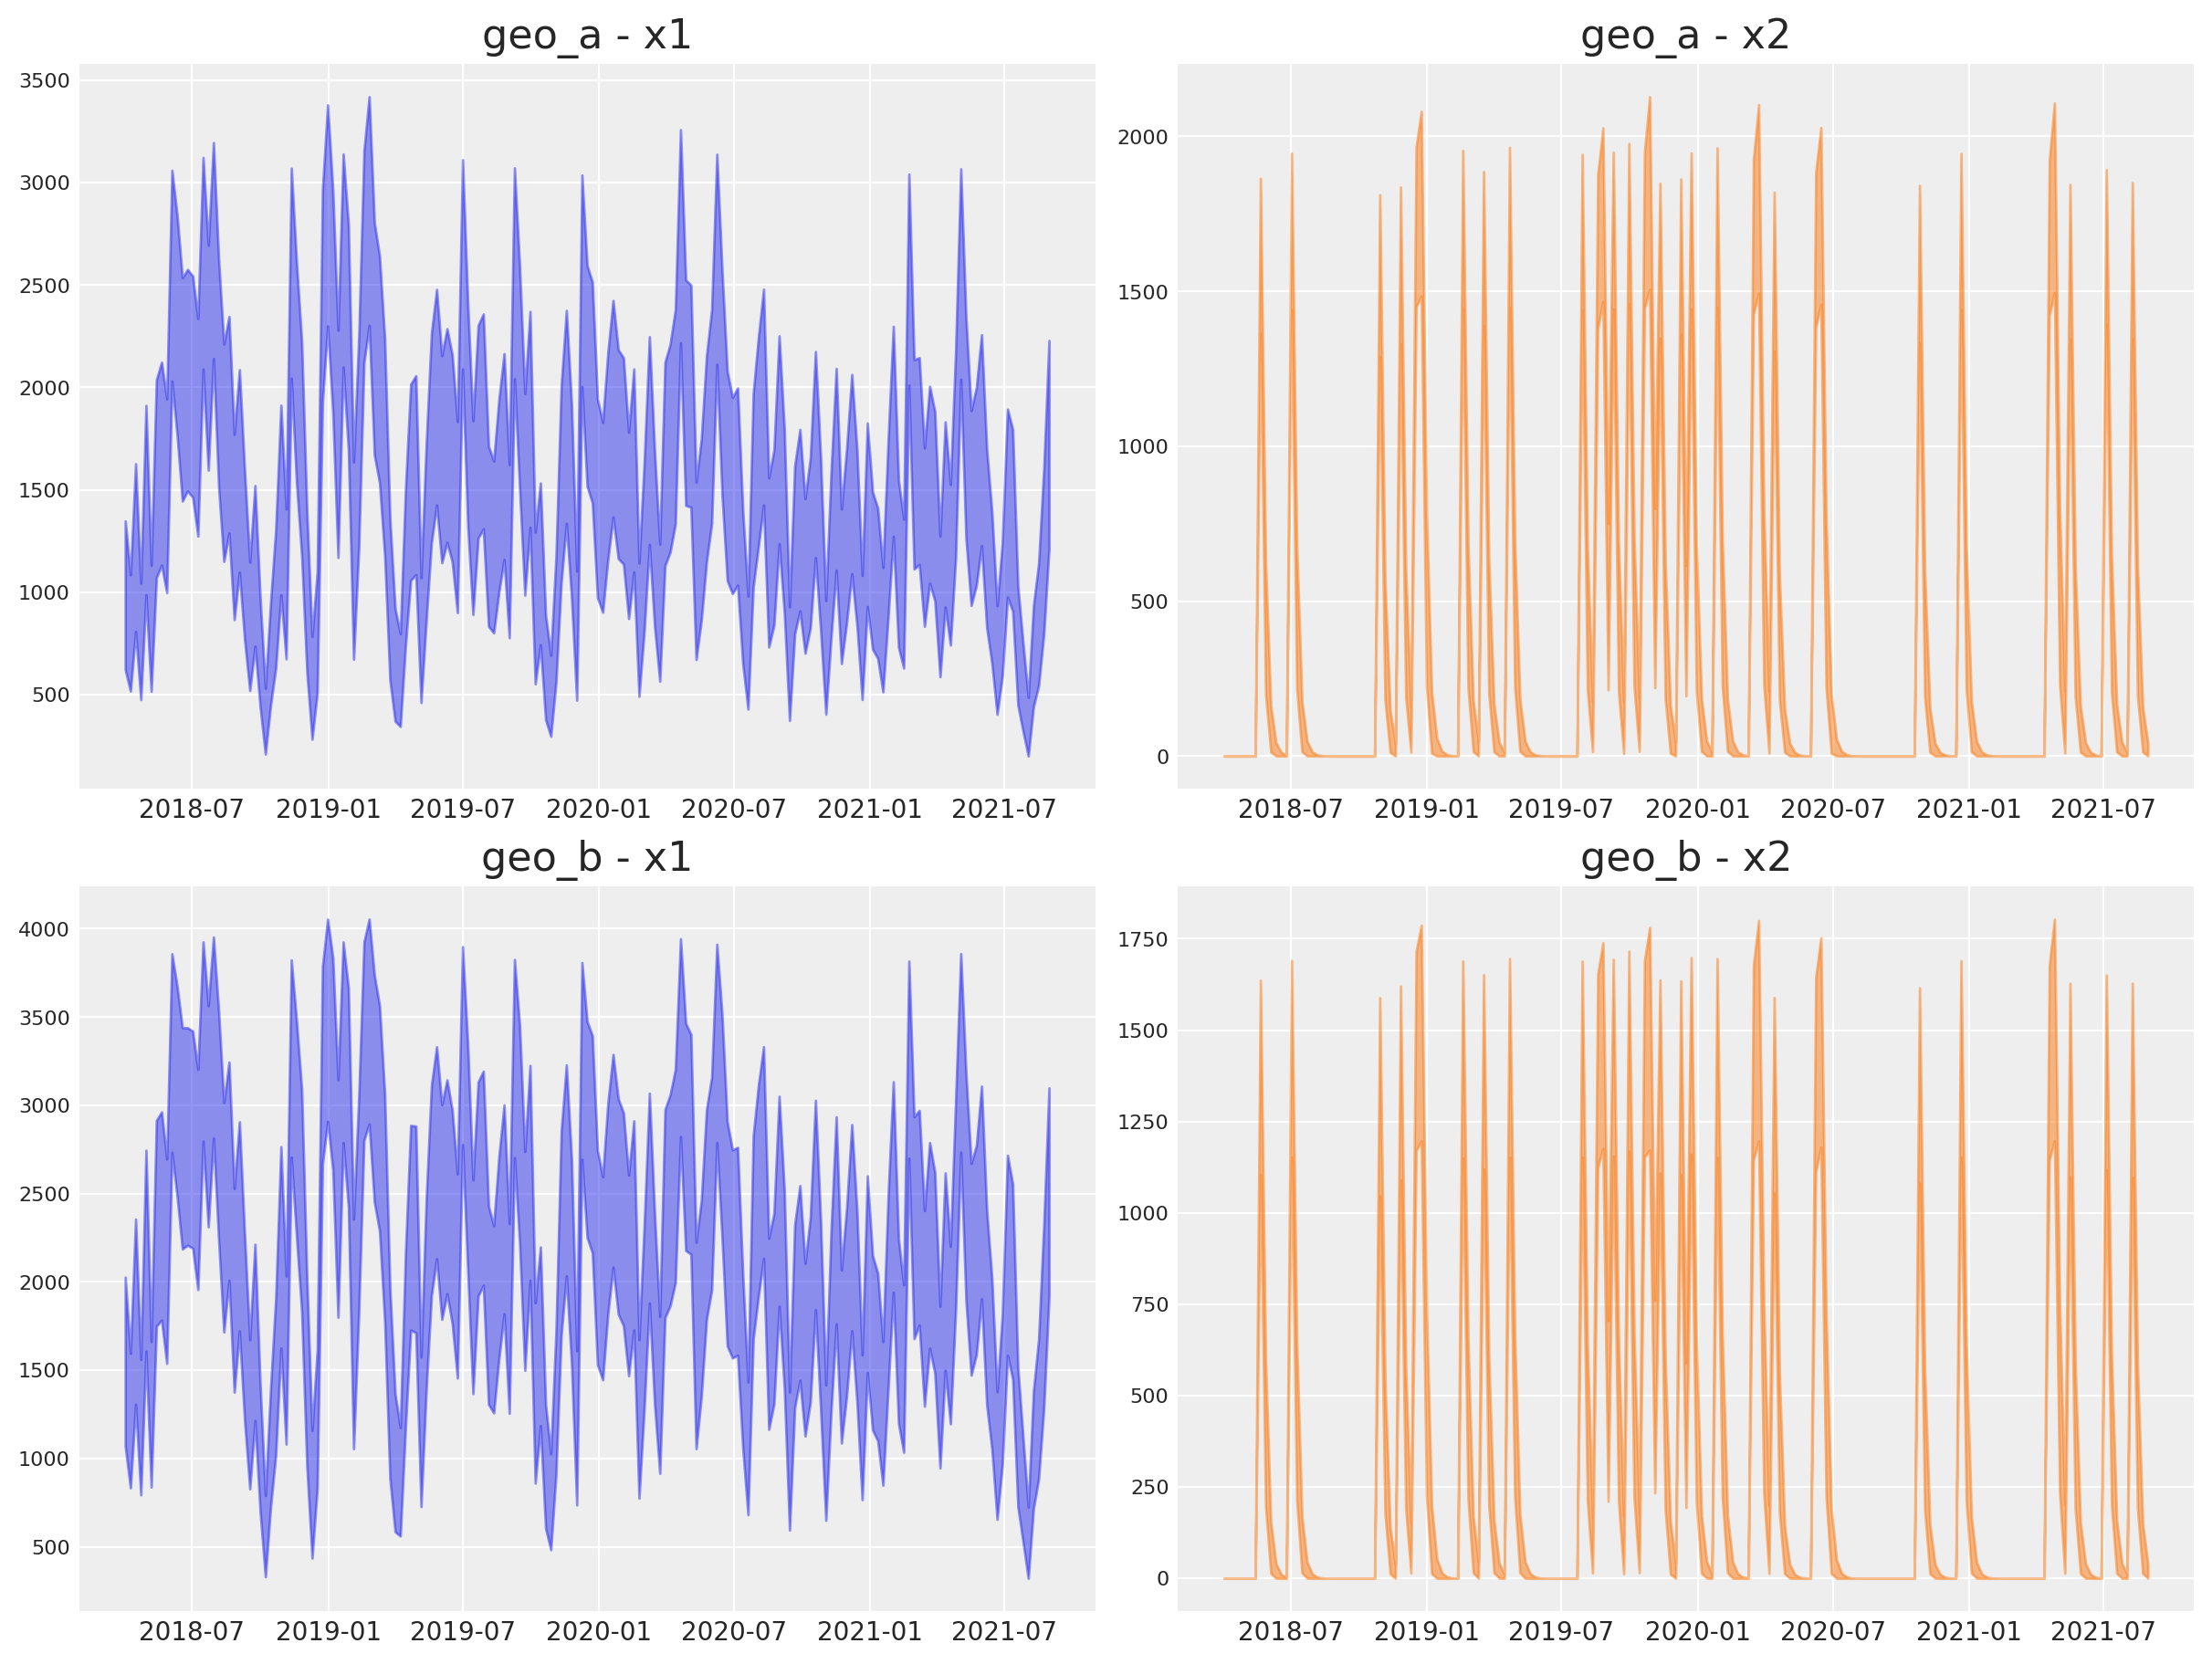

In [23]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
    ncols=len(mmm.model.coords["channel"]),
    figsize=(12, 9),
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    for j, channel in enumerate(mmm.model.coords["channel"]):
        ax = axes[i, j]
        az.plot_hdi(
            x=mmm.model.coords["date"],
            y=mmm.idata["posterior"]["channel_contribution_original_scale"].sel(
                geo=geo, channel=channel
            ),
            color=f"C{j}",
            smooth=False,
            hdi_prob=0.94,
            ax=ax,
        )
        ax.set_title(f"{geo} - {channel}")

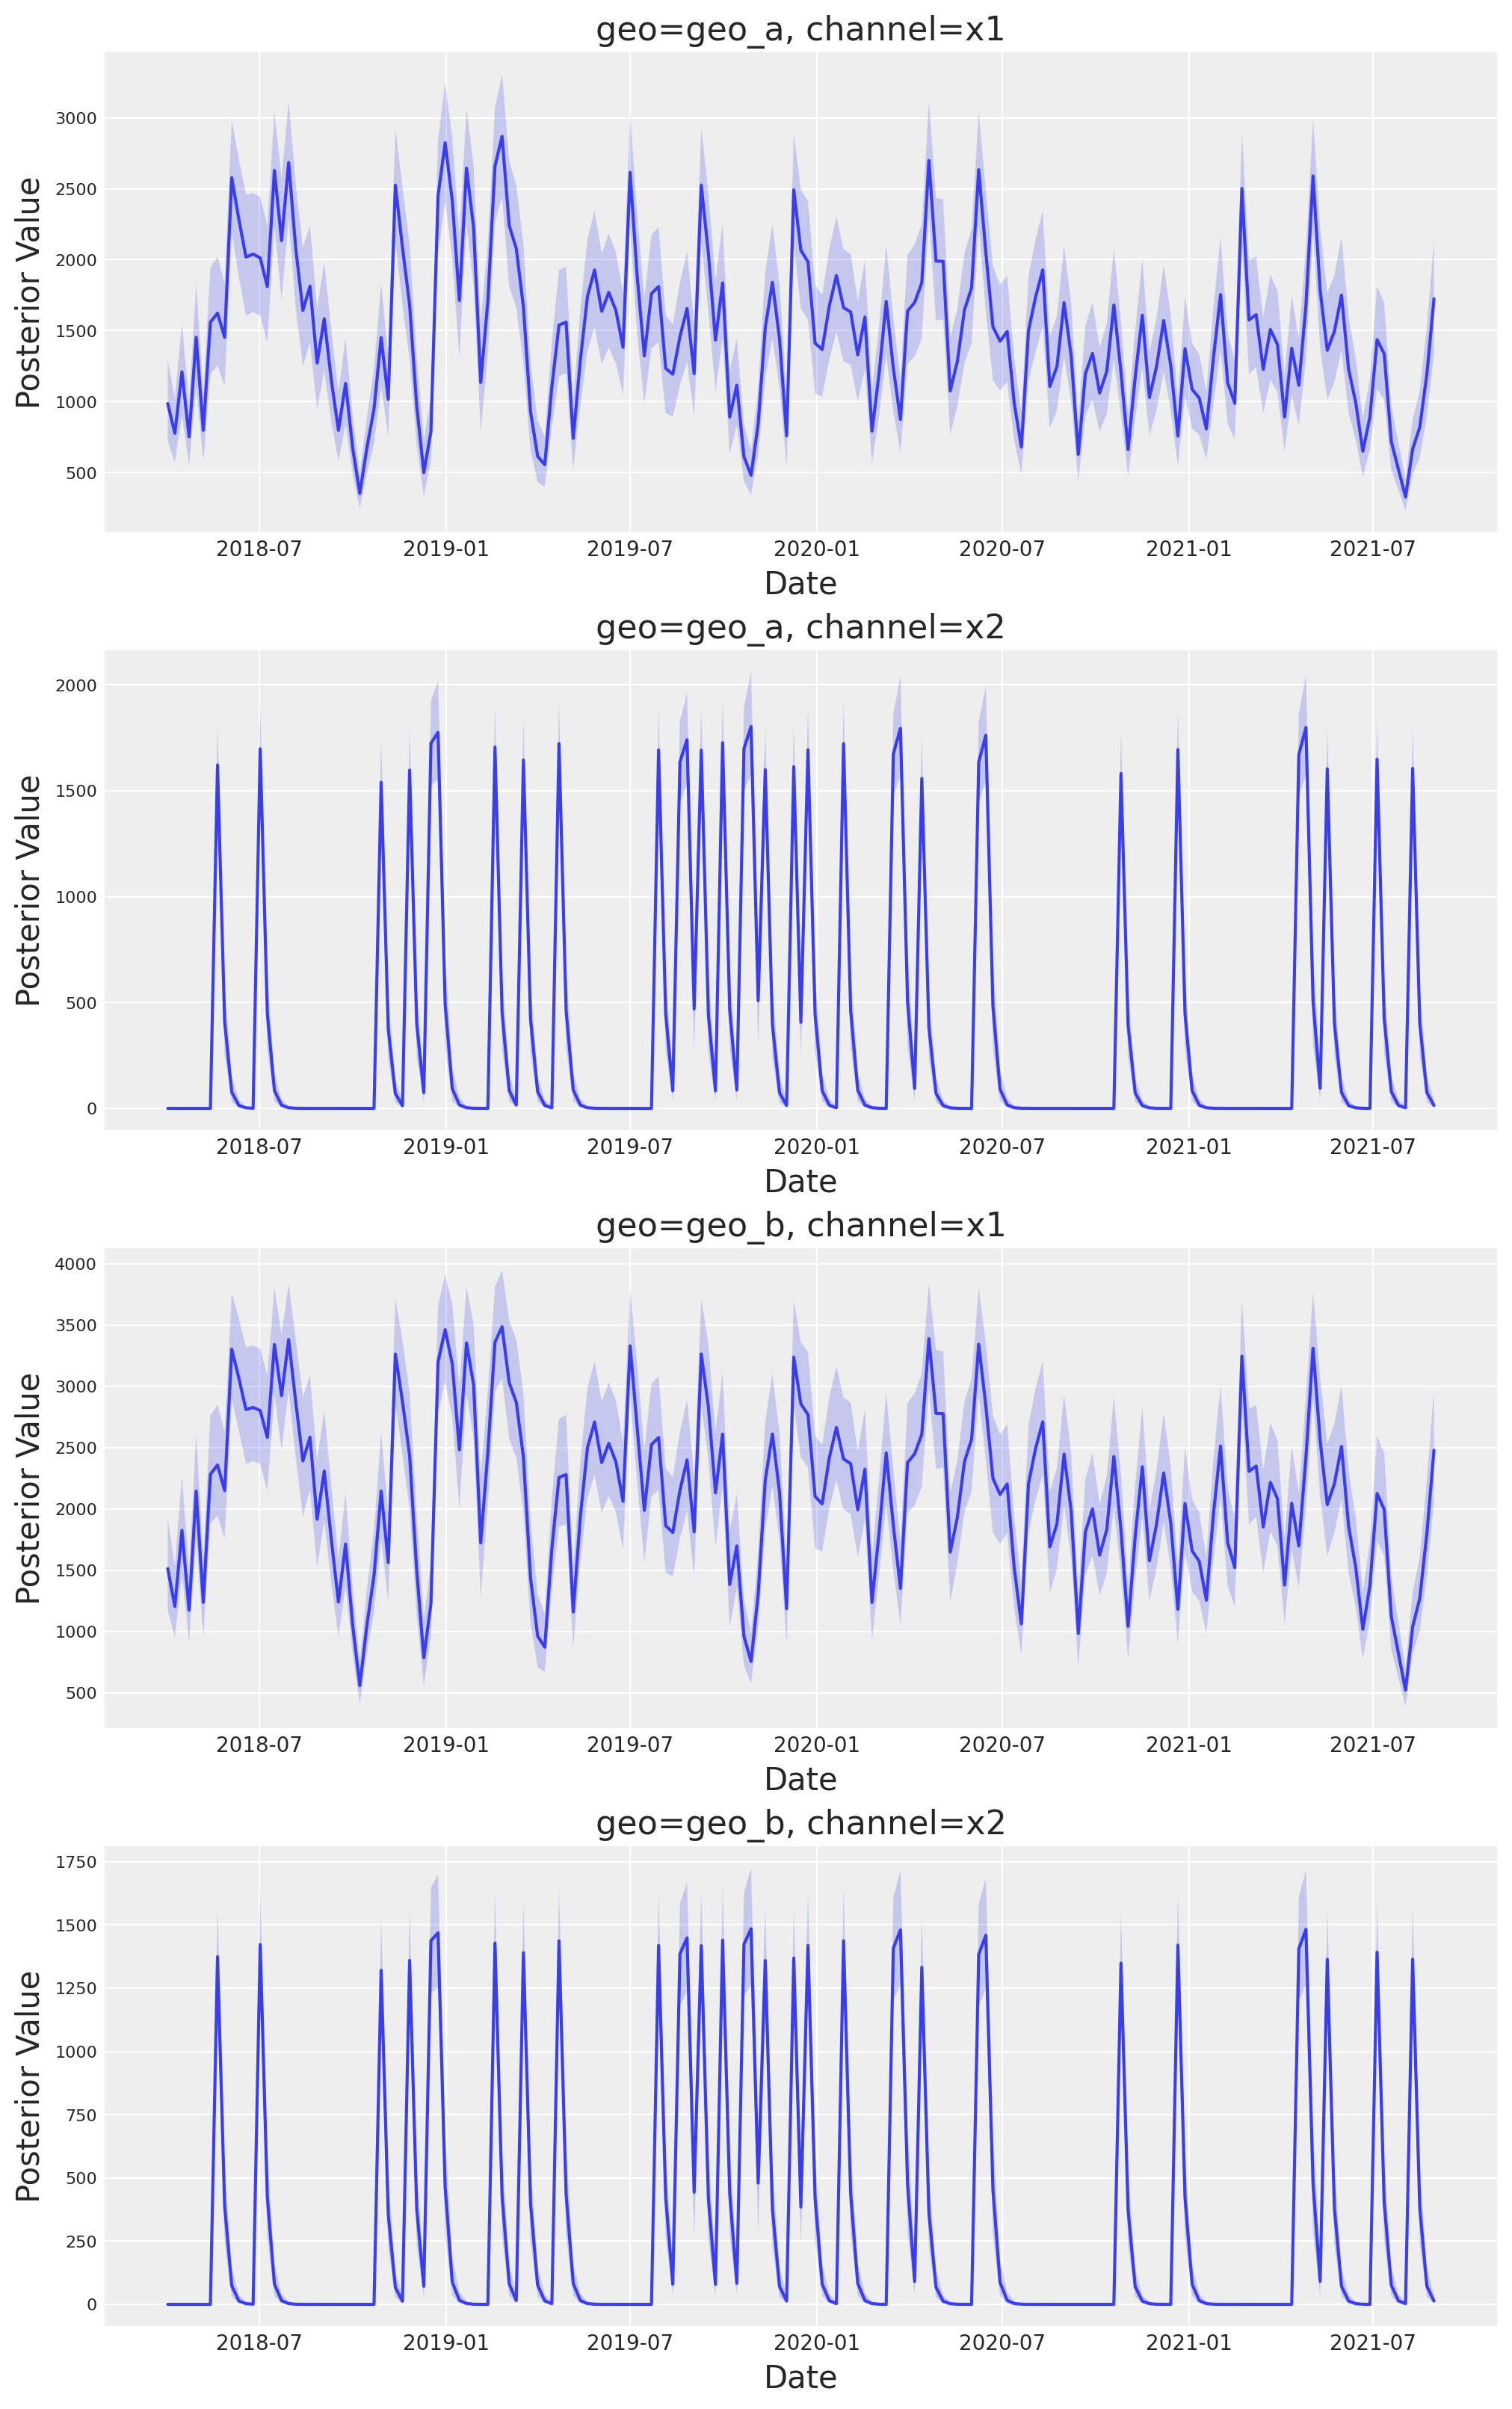

In [24]:
fig, axes = mmm.plot.contributions_over_time(
    var=["channel_contribution_original_scale"]
)

axes = axes.flatten()

for ax in axes:
    ax.legend().remove()

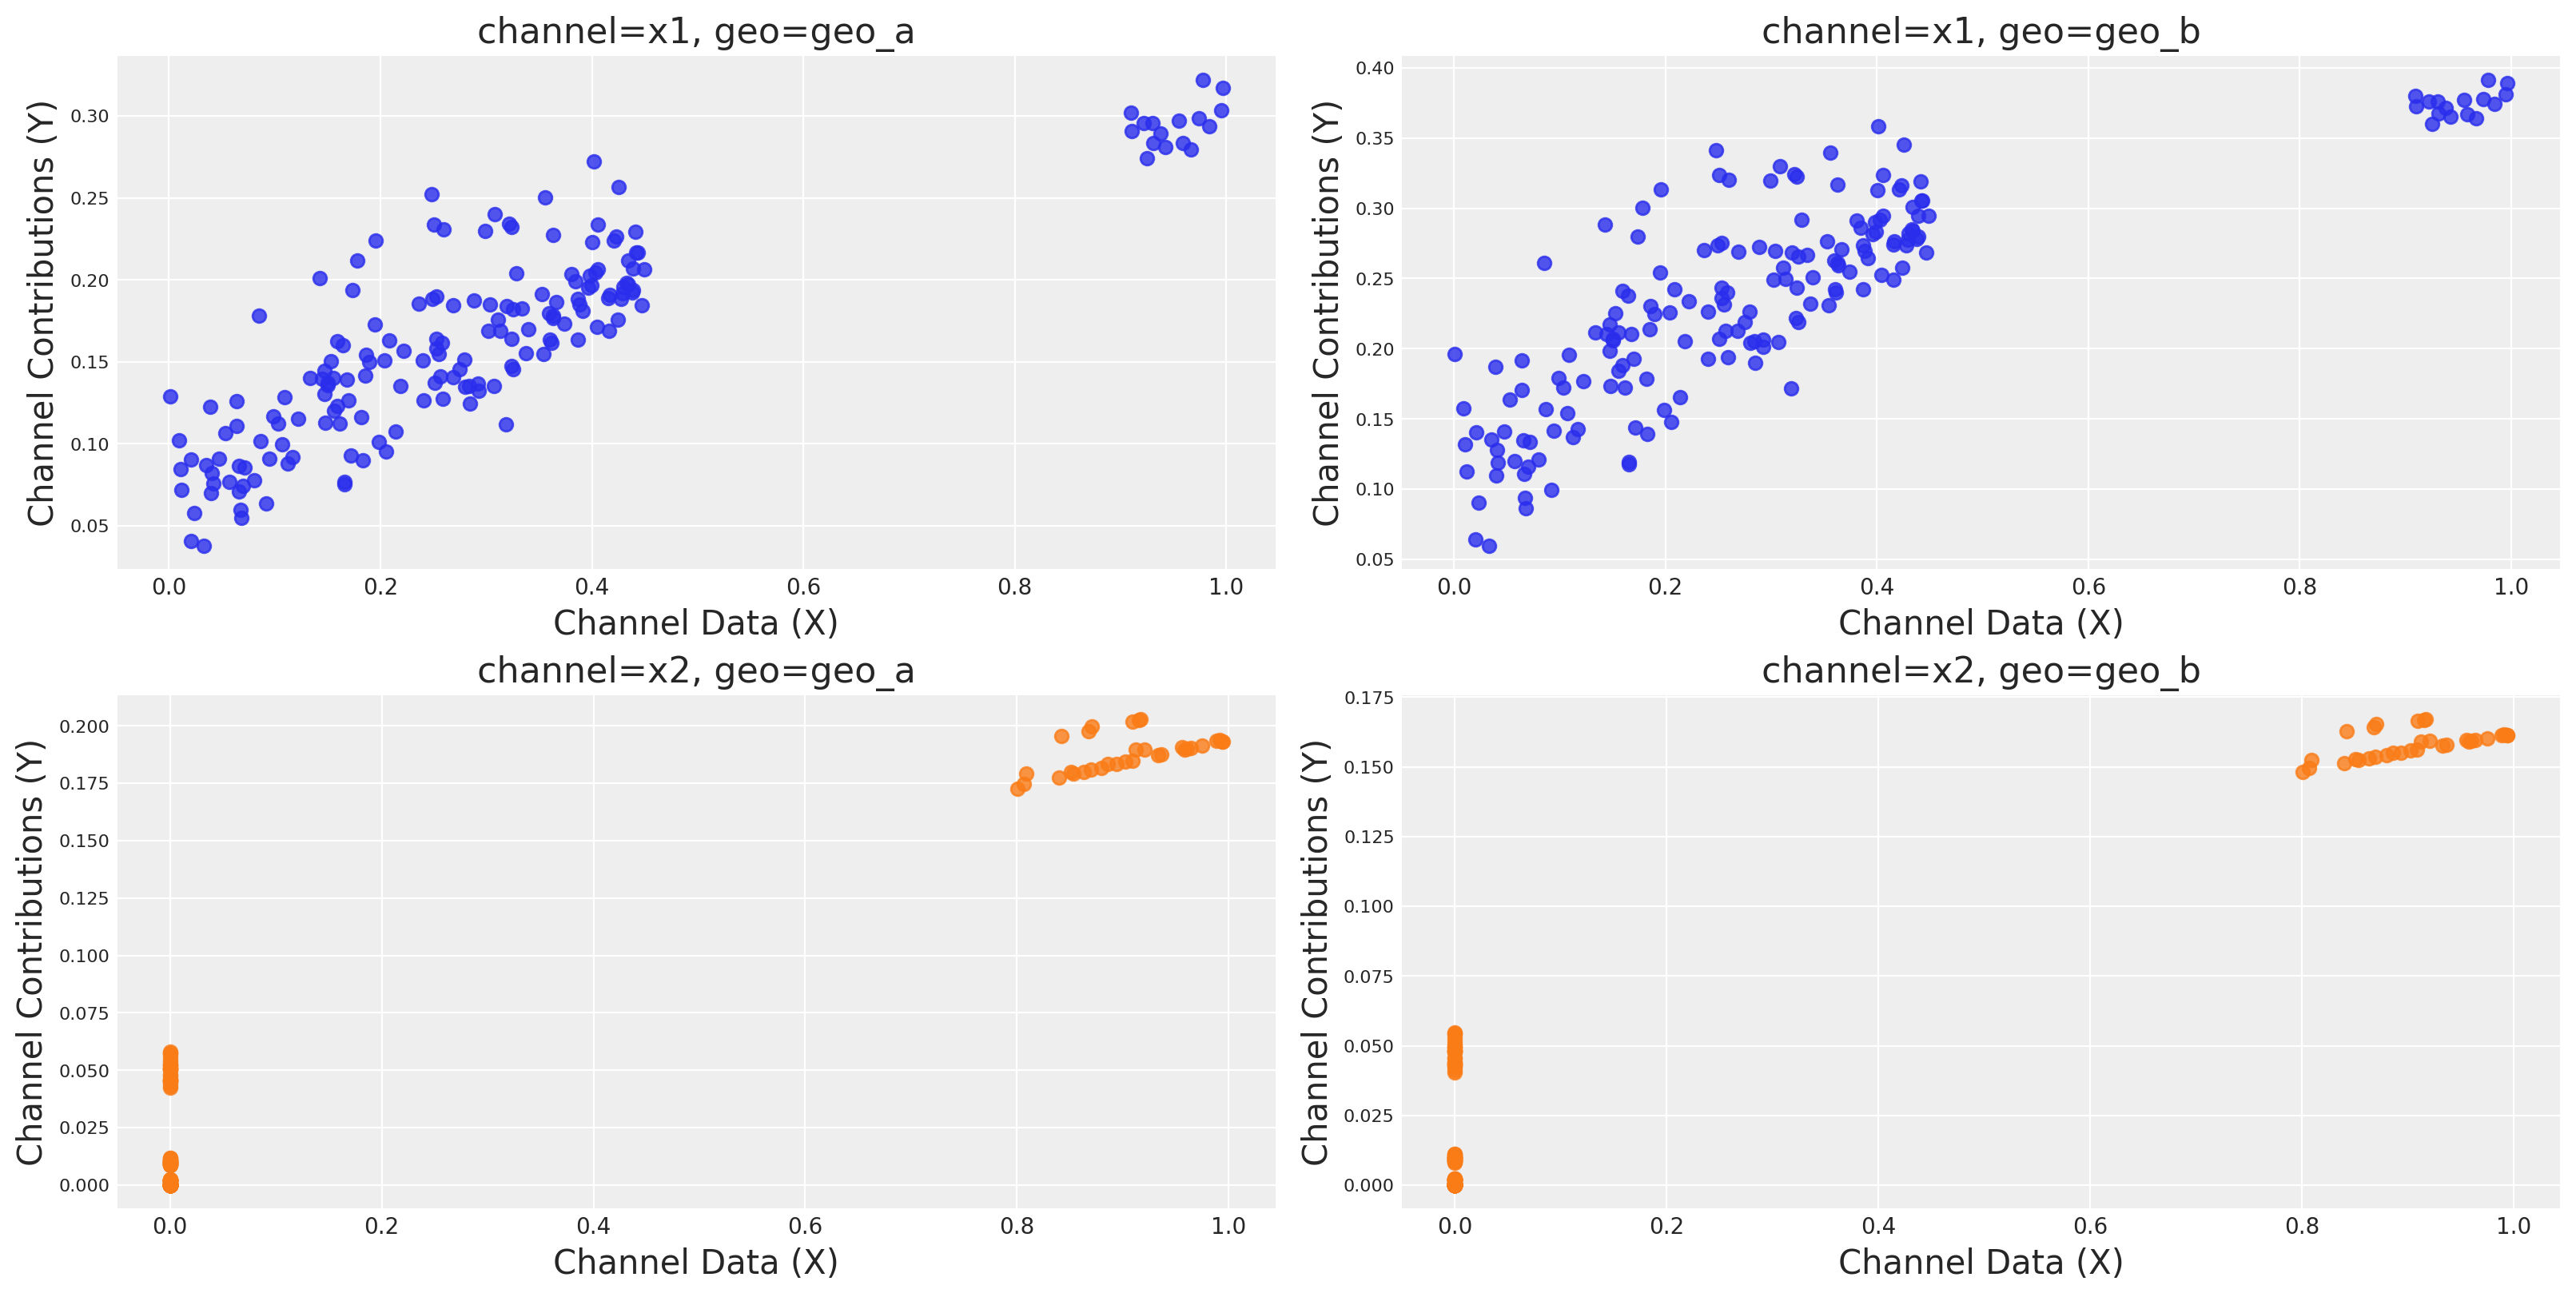

In [25]:
mmm.plot.saturation_curves_scatter(width_per_col=8, height_per_row=4);

In [26]:
last_date = x_train["date"].max()

# New dates starting from last in dataset
n_new = 5
new_dates = pd.date_range(start=last_date, periods=1 + n_new, freq="W-MON")[1:]

x_out_of_sample_geo_a = pd.DataFrame({"date": new_dates, "geo": "geo_a"})

x_out_of_sample_geo_b = pd.DataFrame({"date": new_dates, "geo": "geo_b"})

# Same channel spends as last day
x_out_of_sample_geo_a["x1"] = x_train.query("geo == 'geo_a'")["x1"].iloc[-1]
x_out_of_sample_geo_a["x2"] = x_train.query("geo == 'geo_a'")["x2"].iloc[-1]

x_out_of_sample_geo_b["x1"] = x_train.query("geo == 'geo_b'")["x1"].iloc[-1]
x_out_of_sample_geo_b["x2"] = x_train.query("geo == 'geo_b'")["x2"].iloc[-1]

# Other features
x_out_of_sample_geo_a["event_1"] = 0
x_out_of_sample_geo_a["event_2"] = 0
x_out_of_sample_geo_a["t"] = range(
    len(x_train.query("geo == 'geo_a'")), len(x_train.query("geo == 'geo_a'")) + n_new
)

x_out_of_sample_geo_b["event_1"] = 0
x_out_of_sample_geo_b["event_2"] = 0
x_out_of_sample_geo_b["t"] = range(
    len(x_train.query("geo == 'geo_b'")), len(x_train.query("geo == 'geo_b'")) + n_new
)

x_out_of_sample = pd.concat([x_out_of_sample_geo_a, x_out_of_sample_geo_b])

x_out_of_sample

date    geo        x1   x2  event_1  event_2    t
0 2021-09-06  geo_a  0.438857  0.0        0        0  179
1 2021-09-13  geo_a  0.438857  0.0        0        0  180
2 2021-09-20  geo_a  0.438857  0.0        0        0  181
3 2021-09-27  geo_a  0.438857  0.0        0        0  182
4 2021-10-04  geo_a  0.438857  0.0        0        0  183
0 2021-09-06  geo_b  0.438857  0.0        0        0  179
1 2021-09-13  geo_b  0.438857  0.0        0        0  180
2 2021-09-20  geo_b  0.438857  0.0        0        0  181
3 2021-09-27  geo_b  0.438857  0.0        0        0  182
4 2021-10-04  geo_b  0.438857  0.0        0        0  183

In [27]:
y_out_of_sample = mmm.sample_posterior_predictive(
    x_out_of_sample,
    combined=True,
    extend_idata=False,
    include_last_observations=True,
)

y_out_of_sample

Sampling: [y]


Output()

ValueError: Input dimension mismatch: (input[%i].shape[%i] = %lld, input[%i].shape[%i] = %lld)
Apply node that caused the error: Add(ExpandDims{axis=0}.0, Sum{axis=2}.0, Sum{axis=2}.0, yearly_seasonality_contribution)
Toposort index: 66
Inputs types: [TensorType(float64, shape=(1, None)), TensorType(float64, shape=(None, None)), TensorType(float64, shape=(None, None)), TensorType(float64, shape=(None, None))]
Inputs shapes: [(1, 2), (13, 2), (179, 2), (13, 2)]
Inputs strides: [(8, 8), (16, 8), (16, 8), (16, 8)]
Inputs values: [array([[0.3367612 , 0.25022028]]), 'not shown', 'not shown', 'not shown']
Outputs clients: [[normal_rv{"(),()->()"}(RNG(<Generator(PCG64) at 0x34E757680>), MakeVector{dtype='int64'}.0, mu, ExpandDims{axes=[0, 1]}.0)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.